# Dropout Analysis

In [1]:
#basics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils 
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20

2022-12-14 17:45:57.230740: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Prepare data

In [2]:
# Columns to be considered in the dataset
columns = ["LB", "AC", "FM", "UC", "DL", "DP", 
           "ASTV", "MSTV", "ALTV", "MLTV", "Width", "Min", 
           "Max", "Nmax", "Nzeros", "Mode", "Mean", "Median", "Variance", "Tendency"]

path = "../data/"

## Clean data

For training purpose, import preprocessed data with SMOTE and no outliers:

In [3]:
filename = "prep_data.csv"

df = pd.read_csv(path+filename)
df = df.reindex(np.random.permutation(df.index))

#Prepare X and y
X = df[columns]
y = df["NSP"]

#One-hot enconding of target values 
y_cat = utils.to_categorical(y-1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, train_size=0.8,random_state=45)

## Real data

For testing purpose, import real data:

In [4]:
filename = "CTG.xls"

df_raw = pd.read_excel(path+filename, sheet_name = "Data",header=1)
df_raw = df_raw.reindex(np.random.permutation(df_raw.index))

#Prepare X and y
X_raw = df_raw[columns]
y_raw = df_raw["NSP"]

#One-hot enconding of target values 
y_cat_raw = utils.to_categorical(y_raw-1)

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y_cat_raw, train_size=0.8,random_state=45)

# Dropout application

Dropout is a regularisation method used to reduce over-fitting in a neural network. During training, some layer outputs are randomly ignored along with their incoming and outgoing connections so that the neural network performs each update with a different "view" of the configured layer. The application of this regularisation technique is aimed at improving model performance.

In particular, the model has been tested with different percentages of active nodes for this part of the
analysis and evaluated the results. 
The dropout percentage percentages (i.e., the percentages of nodes discarded at each step):
- 0.10
- 0.30
- 0.50

To reduce the problem’s complexity, the percentage of active nodes in each layer was kept the same.

Useful function:

In [5]:
def evaluate(y_pred, y_test, model_trace):
    
    # Apply argmax
    y_pred = np.argmax(y_pred,axis=1)
    y_compare = np.argmax(y_test,axis=1)
    
    acc = accuracy_score(y_pred,y_compare)
    rec = recall_score(y_pred,y_compare,average="macro")
    
    print("Accuracy: %.2f"%acc)
    print("Recall: %.2f"%rec)

    cm = confusion_matrix(y_compare, y_pred, normalize="all")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["1","2","3"])
    disp.plot()
    
    return acc, rec

## No dropout

The best neural network obtained during the first analysy was:

*HL(100/100/100/100 nodes, relu, epoch=150) x 4*

For this reason, the following analysis has been made employing this structure.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2100      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 3)                 303       
                                                                 
Total params: 32,703
Trainable params: 32,703
Non-trainable params: 0
_________________________________________________________________


2022-12-14 17:46:04.750604: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


31/31 [==============================] - 0s 1ms/step
training time:30.034358024597168
test time:0.16959500312805176
Accuracy: 0.96
Recall: 0.96


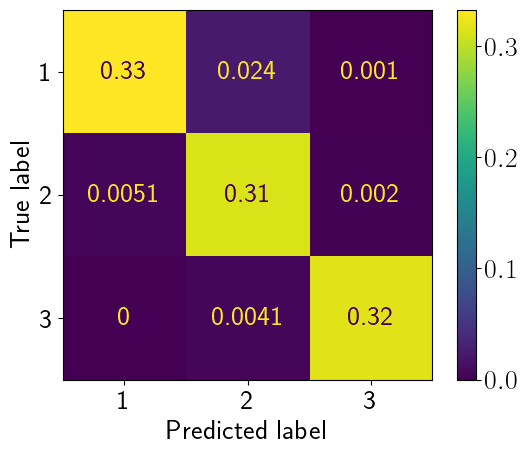

In [6]:
model = Sequential()
model.add(Dense(100, input_dim=X.shape[1], activation='relu')) # Hidden 1
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(y_cat.shape[1], activation='softmax')) # Output
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() #note, only works if input shape specified, or Input layer given

start_fit = time.time()
model_trace_nodrop = model.fit(X_train,y_train, verbose=0,epochs=150, validation_data=(X_test, y_test))
end_fit = time.time()

start_pred = time.time()
y_pred = model.predict(X_test)
end_pred = time.time()

time_fit = end_fit - start_fit;
time_pred = end_pred - start_pred; 

print(f'training time:{time_fit}')
print(f'test time:{time_pred}')
acc_nodrop, rec_nodrop = evaluate(y_pred, y_test, model_trace_nodrop)

## Dropout 0.1

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 60)                1260      
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense_6 (Dense)             (None, 50)                3050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 40)                2040      
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense_8 (Dense)             (None, 30)               

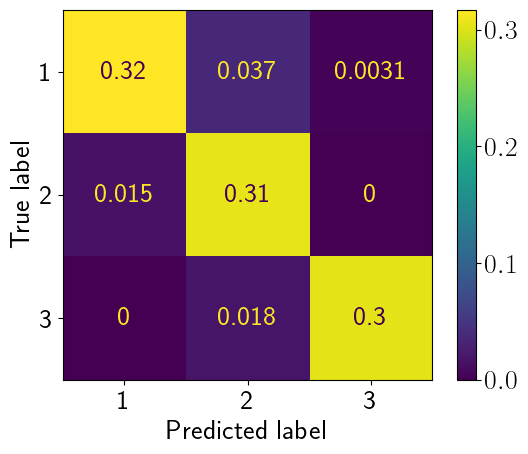

In [7]:
model = Sequential()
model.add(Dense(60, input_dim=X.shape[1], activation='relu')) # Hidden 1
model.add(Dropout(0.1))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(y_cat.shape[1], activation='softmax')) # Output
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() #note, only works if input shape specified, or Input layer given

start_fit = time.time()
model_trace_d01 = model.fit(X_train,y_train, verbose=0,epochs=150, validation_data=(X_test, y_test))
end_fit = time.time()

start_pred = time.time()
y_pred = model.predict(X_test)
end_pred = time.time()

time_fit = end_fit - start_fit;
time_pred = end_pred - start_pred; 

print(f'training time:{time_fit}')
print(f'test time:{time_pred}')
acc_d01, rec_d01= evaluate(y_pred, y_test, model_trace_d01)


## Dropout 0.3

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 60)                1260      
                                                                 
 dropout_4 (Dropout)         (None, 60)                0         
                                                                 
 dense_11 (Dense)            (None, 50)                3050      
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_12 (Dense)            (None, 40)                2040      
                                                                 
 dropout_6 (Dropout)         (None, 40)                0         
                                                                 
 dense_13 (Dense)            (None, 30)               

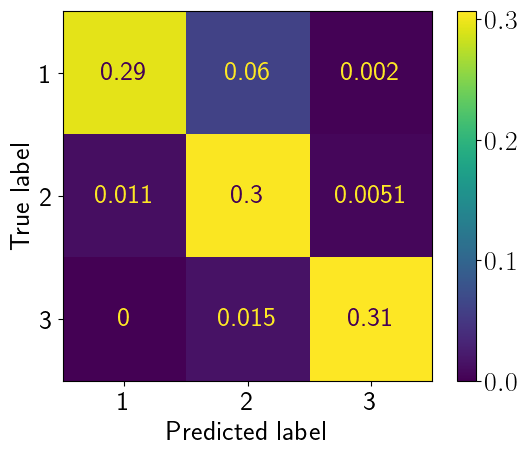

In [8]:
model = Sequential()
model.add(Dense(60, input_dim=X.shape[1], activation='relu')) # Hidden 1
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_cat.shape[1], activation='softmax')) # Output
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() #note, only works if input shape specified, or Input layer given

start_fit = time.time()
model_trace_d03 = model.fit(X_train,y_train, verbose=0,epochs=150, validation_data=(X_test, y_test))
end_fit = time.time()

start_pred = time.time()
y_pred = model.predict(X_test)
end_pred = time.time()

time_fit = end_fit - start_fit;
time_pred = end_pred - start_pred; 

print(f'training time:{time_fit}')
print(f'test time:{time_pred}')
acc_d03, rec_d03 =  evaluate(y_pred, y_test, model_trace_d03)



## Dropout 0.5

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 60)                1260      
                                                                 
 dropout_8 (Dropout)         (None, 60)                0         
                                                                 
 dense_16 (Dense)            (None, 50)                3050      
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_17 (Dense)            (None, 40)                2040      
                                                                 
 dropout_10 (Dropout)        (None, 40)                0         
                                                                 
 dense_18 (Dense)            (None, 30)               

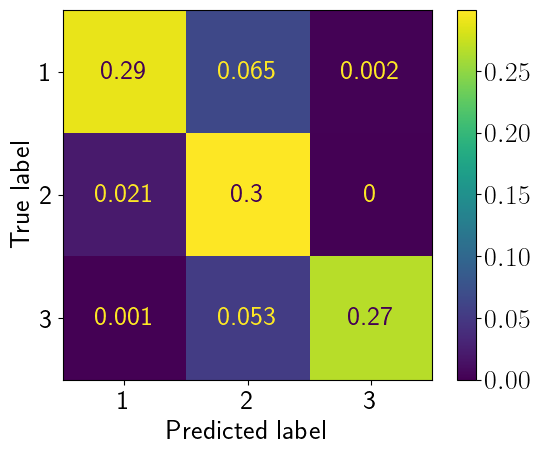

In [9]:
model = Sequential()
model.add(Dense(60, input_dim=X.shape[1], activation='relu')) # Hidden 1
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_cat.shape[1], activation='softmax')) # Output
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() #note, only works if input shape specified, or Input layer given

start_fit = time.time()
model_trace_d05 = model.fit(X_train,y_train, verbose=0,epochs=150,validation_data=(X_test, y_test))
end_fit = time.time()

start_pred = time.time()
y_pred = model.predict(X_test)
end_pred = time.time()

time_fit = end_fit - start_fit;
time_pred = end_pred - start_pred; 

print(f'training time:{time_fit}')
print(f'test time:{time_pred}')
acc_d05, rec_d05 =   evaluate(y_pred, y_test, model_trace_d05)


# Comparison between dropout and no dropout

We can see that the loss function and the accuracy (except for 0.1) for the model trained without dropout are lower than the models trained with dropout, increasing with the number of nodes removed. This difference arises because dropout removes nodes from the layers and thus increases the number of iterations required to converge.

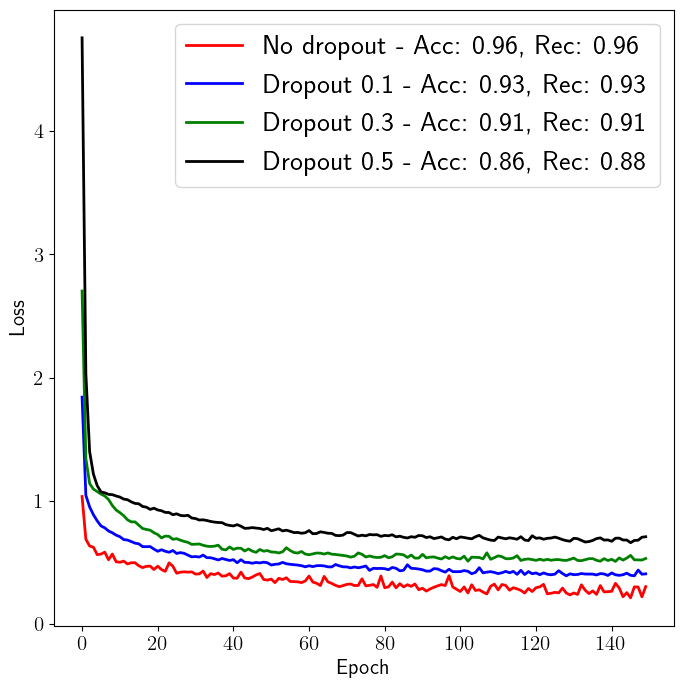

In [13]:
# Plot the loss function
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(np.sqrt(model_trace_nodrop.history['loss']),  'r', linewidth=2.0,  label='No dropout - Acc: %.2f, Rec: %.2f'%(acc_nodrop,rec_nodrop))
ax.plot(np.sqrt(model_trace_d01.history['loss']), 'b',linewidth=2.0, label='Dropout 0.1 - Acc: %.2f, Rec: %.2f'%(acc_d01,rec_d01))
ax.plot(np.sqrt(model_trace_d03.history['loss']), 'g', linewidth=2.0,label='Dropout 0.3 - Acc: %.2f, Rec: %.2f'%(acc_d03,rec_d03))
ax.plot(np.sqrt(model_trace_d05.history['loss']), 'k', linewidth=2.0,label='Dropout 0.5 - Acc: %.2f, Rec: %.2f'%(acc_d05,rec_d05))
ax.set_xlabel(r'Epoch', fontsize=15)
ax.set_ylabel(r'Loss', fontsize=15)
ax.legend()
ax.tick_params(labelsize=15)

#plt.savefig("../results/dropout_loss")

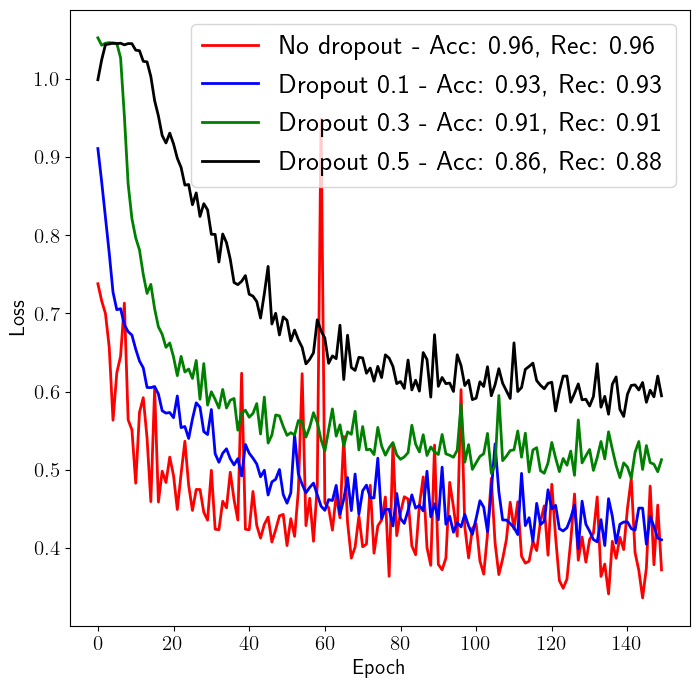

In [11]:
# Plot the validation loss function
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(np.sqrt(model_trace_nodrop.history['val_loss']),  'r', linewidth=2.0,  label='No dropout - Acc: %.2f, Rec: %.2f'%(acc_nodrop,rec_nodrop))
ax.plot(np.sqrt(model_trace_d01.history['val_loss']), 'b',linewidth=2.0, label='Dropout 0.1 - Acc: %.2f, Rec: %.2f'%(acc_d01,rec_d01))
ax.plot(np.sqrt(model_trace_d03.history['val_loss']), 'g', linewidth=2.0,label='Dropout 0.3 - Acc: %.2f, Rec: %.2f'%(acc_d03,rec_d03))
ax.plot(np.sqrt(model_trace_d05.history['val_loss']), 'k', linewidth=2.0,label='Dropout 0.5 - Acc: %.2f, Rec: %.2f'%(acc_d05,rec_d05))
ax.set_xlabel(r'Epoch', fontsize=15)
ax.set_ylabel(r'Loss', fontsize=15)
ax.legend()
ax.tick_params(labelsize=15)

#plt.savefig("../results/dropout_val_loss")